# Experiment 06: Analysis with Post-processing

### Summary
This notebook evaluates the impact of the post-processing step described in the "RAovSeg" paper. We take the best model from our previous long-training experiment (`13_...ipynb`) and apply post-processing (binary closing + keeping the largest connected component) to its raw predictions on the validation set.

### **Methodology**

*   **Objective**: Quantify the performance improvement gained by applying post-processing to the output of our best model so far.
*   **Model Used**: The saved `AttentionUNet` from Experiment 04 (trained for 50 epochs with custom preprocessing and Focal Tversky Loss).
*   **Analysis Steps**:
    1.  Load the pre-trained model.
    2.  Iterate over the entire validation set.
    3.  For each sample, calculate the Dice score on the raw prediction.
    4.  Apply the `postprocess_` function to the raw prediction.
    5.  Calculate the Dice score on the post-processed prediction.
    6.  Report the average Dice scores for both "before" and "after" to measure the impact.
    7.  Visualize a few examples to confirm the effect.

Successfully loaded model from ../models/14_attn_unet_focal_tversky_best.pth
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Loaded 64 validation slices for analysis.



Analyzing Validation Set: 100%|██████████| 64/64 [00:10<00:00,  6.14it/s]



--- Quantitative Analysis Results ---
Average Validation Dice Score BEFORE Post-processing: 0.3090
Average Validation Dice Score AFTER Post-processing:  0.2988
Improvement: -0.0102

Visualizing 5 sample predictions...


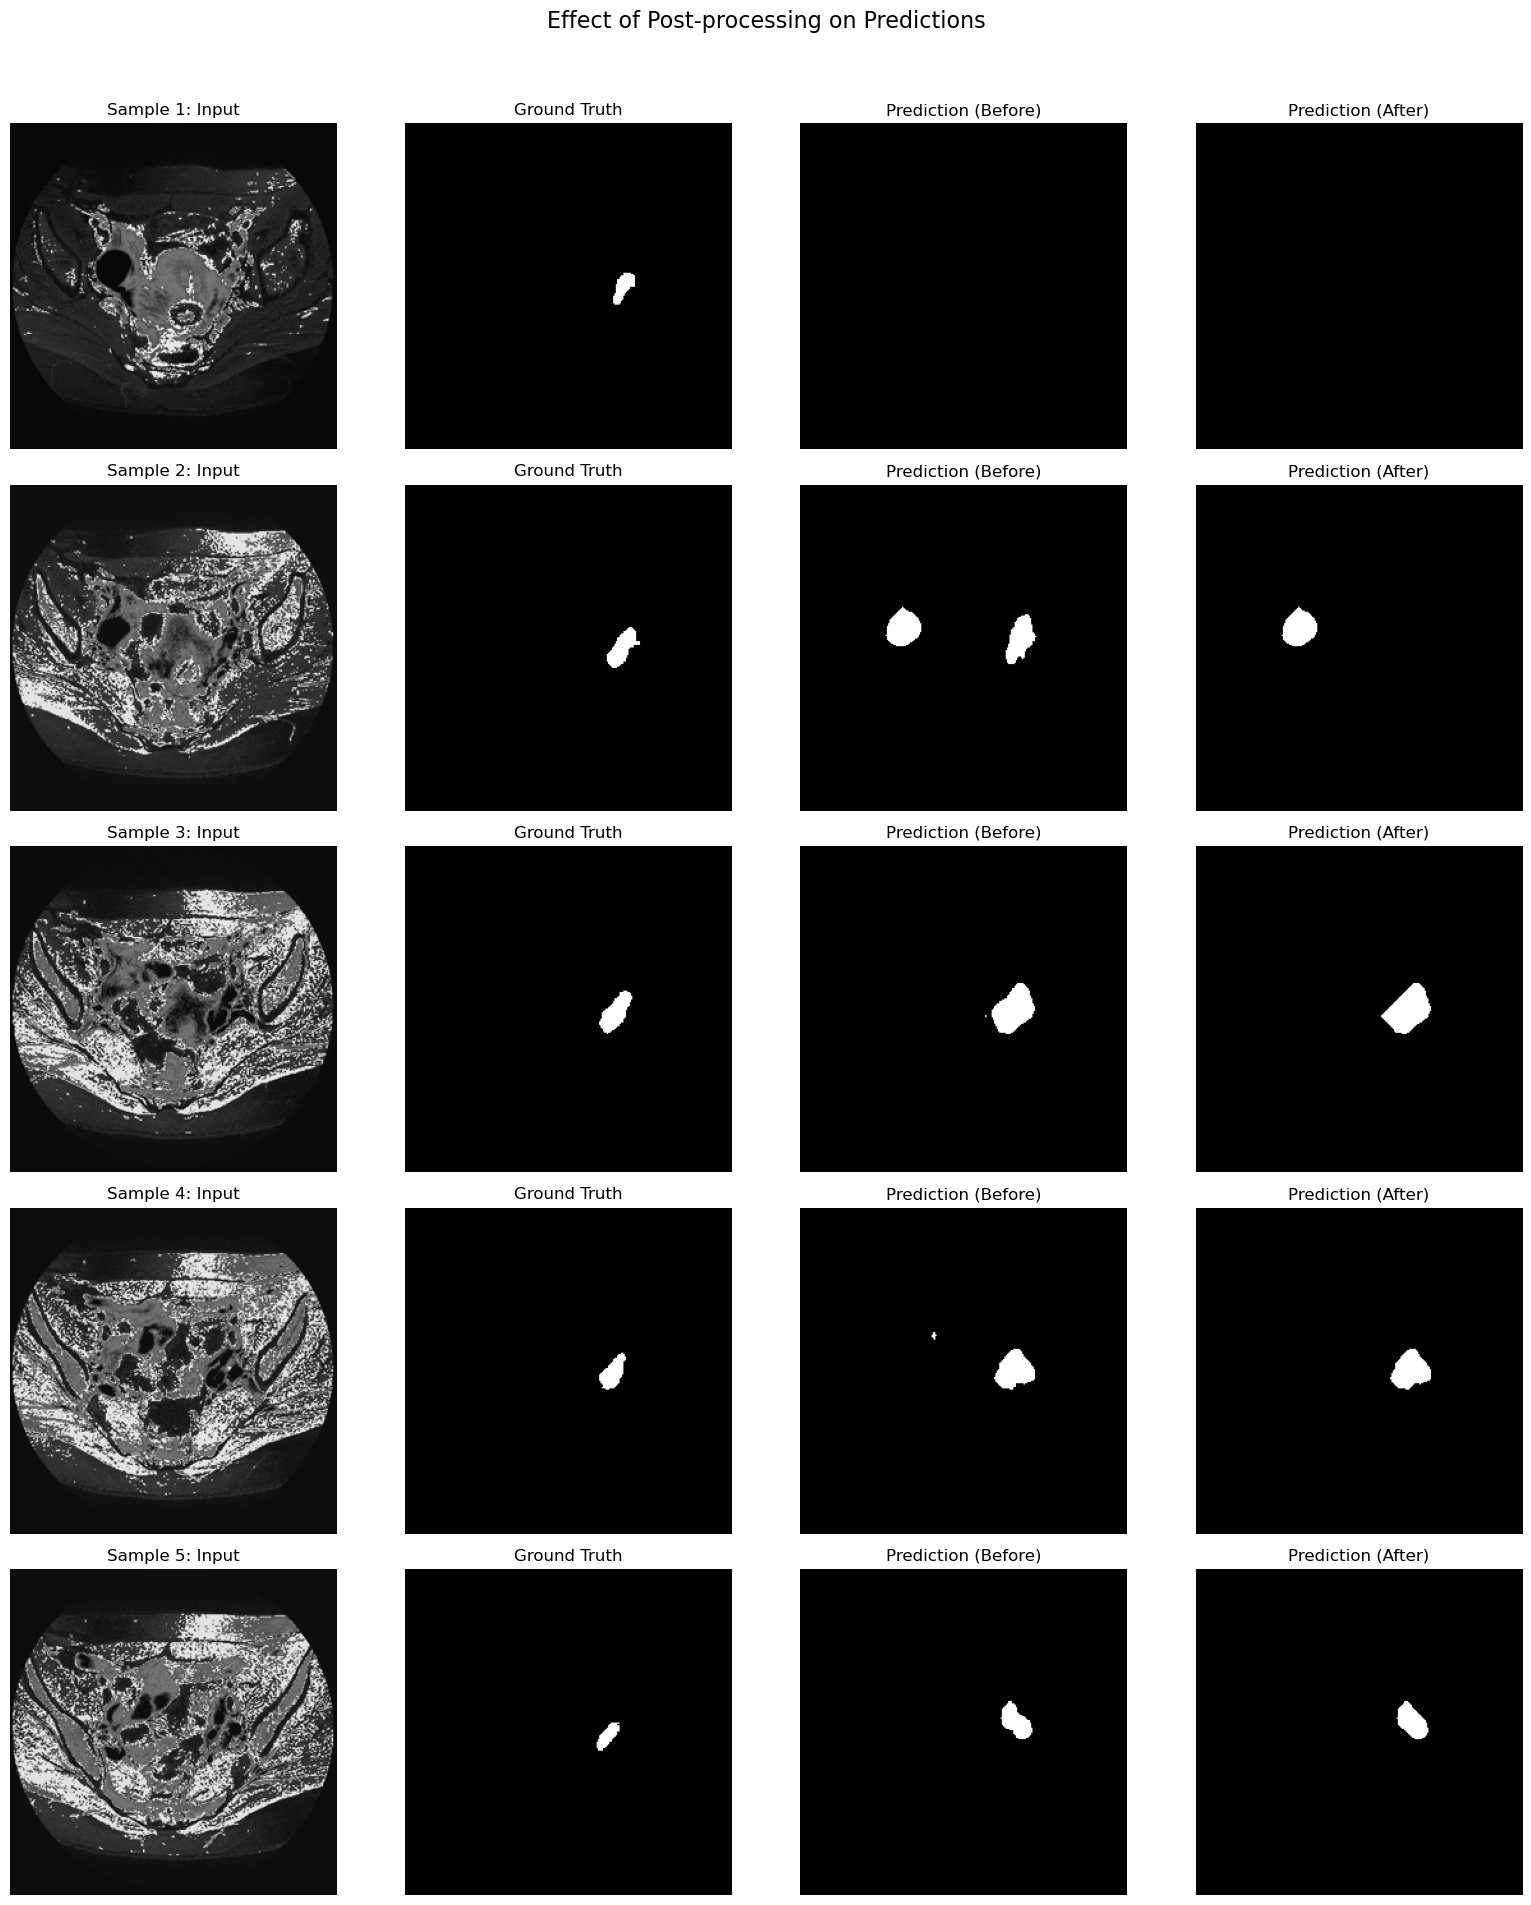

In [1]:
# --- Imports and Setup ---
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import numpy as np

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDatasetWithPreprocessing 
from src.models import AttentionUNet
from src.RAovSeg_tools import postprocess_ # <--- Import the post-processing function

# --- Configuration ---
model_path = "../models/14_attn_unet_focal_tversky_best.pth" # <--- Path to the model from the last experiment
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
num_samples_to_show = 5

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(n_channels=1, n_classes=1).to(device)

try:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Successfully loaded model from {model_path}")
except FileNotFoundError:
    print(f"FATAL ERROR: Model file not found at {model_path}. Please run the training in notebook 15.")
    exit()

# --- Load Validation Data ---
val_full_dataset = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=False)
patient_ids = val_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
val_ids = patient_ids[split_idx:]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]
val_dataset = Subset(val_full_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print(f"Loaded {len(val_dataset)} validation slices for analysis.\n")

# --- Quantitative Analysis: Calculate Dice Scores Before and After Post-processing ---

def dice_score(preds, targets, epsilon=1e-6):
    preds_flat, targets_flat = preds.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

dice_scores_before = []
dice_scores_after = []

with torch.no_grad():
    for image, mask in tqdm(val_loader, desc="Analyzing Validation Set"):
        image, mask = image.to(device), mask.to(device)
        
        # 1. Get raw prediction
        output = model(image)
        pred_mask_raw = torch.sigmoid(output) > 0.5
        
        # 2. Calculate Dice score BEFORE post-processing
        dice_before = dice_score(pred_mask_raw, mask)
        dice_scores_before.append(dice_before.cpu().item())
        
        # 3. Apply post-processing
        pred_mask_raw_np = pred_mask_raw.cpu().squeeze().numpy()
        pred_mask_post_np = postprocess_(pred_mask_raw_np)
        
        # 4. Calculate Dice score AFTER post-processing
        pred_mask_post_tensor = torch.from_numpy(pred_mask_post_np).unsqueeze(0).unsqueeze(0).to(device)
        dice_after = dice_score(pred_mask_post_tensor, mask)
        dice_scores_after.append(dice_after.cpu().item())

# Calculate and print average scores
avg_dice_before = np.mean(dice_scores_before)
avg_dice_after = np.mean(dice_scores_after)

print("\n--- Quantitative Analysis Results ---")
print(f"Average Validation Dice Score BEFORE Post-processing: {avg_dice_before:.4f}")
print(f"Average Validation Dice Score AFTER Post-processing:  {avg_dice_after:.4f}")
print(f"Improvement: {avg_dice_after - avg_dice_before:+.4f}")


# --- Qualitative Analysis: Visualize Predictions ---
print(f"\nVisualizing {num_samples_to_show} sample predictions...")

fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(16, num_samples_to_show * 4))
fig.suptitle("Effect of Post-processing on Predictions", fontsize=16)

with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples_to_show:
            break
        
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        pred_mask_raw = torch.sigmoid(output) > 0.5
        
        # Post-process for visualization
        pred_mask_post = postprocess_(pred_mask_raw.cpu().squeeze().numpy())

        # Convert all to numpy for plotting
        image_np = image.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_mask_raw_np = pred_mask_raw.cpu().squeeze().numpy()
        
        # Plotting
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title(f"Sample {i+1}: Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask_raw_np, cmap='gray')
        axes[i, 2].set_title("Prediction (Before)")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(pred_mask_post, cmap='gray')
        axes[i, 3].set_title("Prediction (After)")
        axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Analysis of Post-processing (Experiment 06)

### Summary
This notebook analyzes the effect of applying the paper's post-processing method (binary closing and keeping the largest connected component) to the predictions of our best model from Experiment 05.

### Quantitative Findings
- **Performance Change**: The post-processing step resulted in a slight **decrease** in the average validation Dice score.
    - Average Dice Score (Before): **0.3090**
    - Average Dice Score (After):  **0.2988**
    - Improvement: **-0.0102**

### Qualitative Findings (Visual Analysis)
The visual analysis reveals the reason for the drop in performance and highlights a key weakness in our current model.
- **Identified Problem**: The model often produces multiple predictions for a single slice, and it is frequently more confident (i.e., predicts a larger area) for an incorrect region than for the true ovary.
- **Failure Mode**: The post-processing logic, which keeps only the single largest predicted region, therefore often **discards the correct, smaller true positive** while keeping a larger false positive (e.g., Samples 2, 3).
- **Success Case**: In cases where the model's largest prediction was correct and it also produced smaller, spurious noise, the post-processing worked as intended and successfully cleaned up the prediction (e.g., Sample 4).

### Conclusion & Next Steps
This experiment is highly valuable. It demonstrates that while the post-processing logic can clean up minor noise, it is not a solution for a model that is fundamentally uncertain. The core issue is that the model is still being forced to segment slices where it gets confused by other tissues that mimic the appearance of an ovary.

This provides the definitive motivation for our next step: implementing the **`ResClass` slice selection classifier**. By first training a model whose only job is to identify which slices are worth segmenting, we can prevent the segmentation model from ever seeing these confusing "negative" slices. This should dramatically reduce the occurrence of these large, confident false positives and allow the post-processing step to be much more effective.